In [1]:
import torch
from SVI_solver_library.transform.AdapterTransform import AdapterTransform as Adapter
from SVI_solver_library.solver.ProjSolver import ProjSolver as ProjSolver

In [2]:
def P_X(u, l, h):
    return torch.where(u < l, l, torch.where(u > h, h, u))

In [3]:
def P_ex(u):
    return P_X(u, torch.tensor([1, 0, 0, 1], dtype=torch.double), 100)

In [4]:
def F_ex(u):
    return torch.tensor([3*u[0] - 1/(u[0] + 0.1) + 3*u[1] - 2,
                  3*u[0] + 3 * u[1],
                  4*u[2] + 3*u[3],
                  4*u[2] + 4*u[3] - 1 / (u[3] + 0.1) - 3],dtype=torch.double)

In [5]:
F = Adapter(F_ex)
P = Adapter(P_ex)
Ex_solver = ProjSolver(F, torch.tensor([4, 4, 4, 4], dtype=torch.double), P = P)
u_ex = torch.rand(4, dtype=torch.double)
answer, verbose = Ex_solver.solve(u_ex)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]

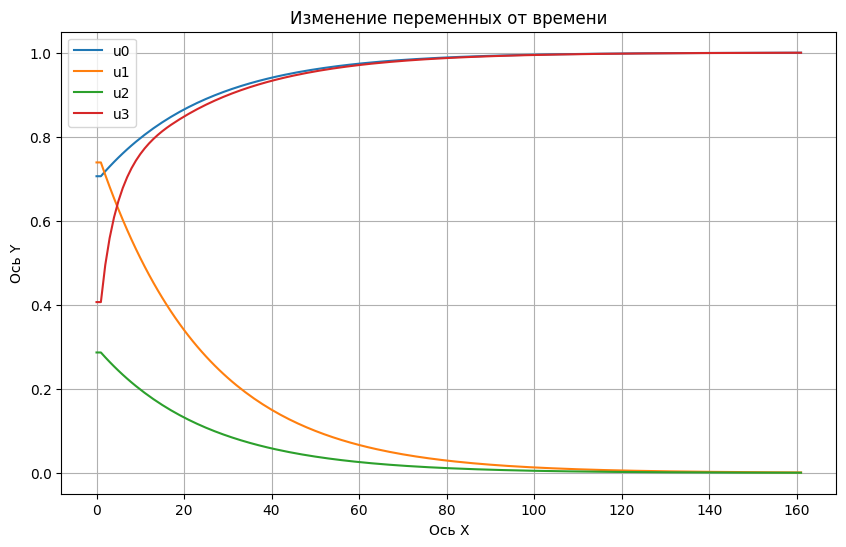

In [8]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 


plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()

In [9]:
def project(x, C):
    norm = np.linalg.norm(x)
    if norm > 1:
        return x / norm
    return x

In [10]:
def P_ex1(u):
    return project(u, 1)

In [11]:
def F_ex1(u):
    return 4*u**3 - 4*u

In [12]:
F_1 = Adapter(F_ex1)
P_1 = Adapter(P_ex1)
Ex_solver = ProjSolver(F_1, torch.tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=torch.double), P = P_1)
u_ex = torch.rand(10, dtype=torch.double)
answer, verbose = Ex_solver.solve(u_ex)

In [13]:
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

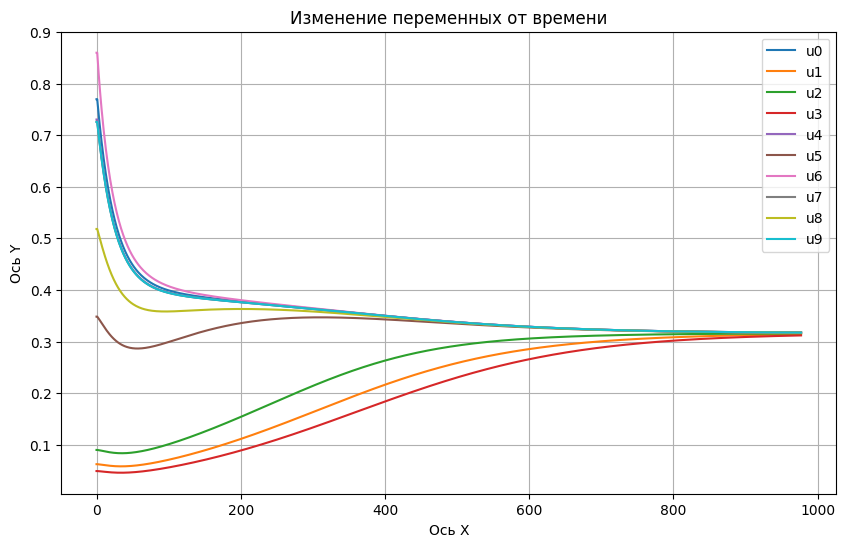

In [14]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 
plt.plot(u4_history.numpy(), label='u4') 
plt.plot(u5_history.numpy(), label='u5') 
plt.plot(u6_history.numpy(), label='u6') 
plt.plot(u7_history.numpy(), label='u7') 
plt.plot(u8_history.numpy(), label='u8') 
plt.plot(u9_history.numpy(), label='u9') 


plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()

In [15]:
answer

tensor([0.3173, 0.3139, 0.3157, 0.3119, 0.3173, 0.3172, 0.3173, 0.3173, 0.3172,
        0.3173], dtype=torch.float64)

In [16]:
import numpy as np
import time

def f(x):
    return np.sum(x**4 - 2*x**2)

def G(x):
    return 4*x**3 - 4*x

def J(x):
    return np.diag(12*x**2 - 4)

def project(x, C):
    norm = np.linalg.norm(x)
    if norm > C:
        return x / norm
    return x

def variational_inequality(G, x, C, max_iter=1000, tol=1e-5):
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        x_new = project(x - G(x), C)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

def newton_method(G, J, x0, C, max_iter=1000, tol=1e-10):
    x = x0
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        J_inv = np.linalg.inv(J(x))
        dx = -np.dot(J_inv, G(x))
        x_new = project(x + dx, C)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

def extragradient_method(G, x0, C, learning_rate=0.1, max_iter=1000, tol=1e-5):
    x = x0
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        y = project(x - learning_rate * G(x), C)
        x_new = project(x - learning_rate * G(y), C)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

def phi_alpha(G, x, alpha, C):
    def Phi_alpha(x, y):
        return np.dot(G(x), x - y) - (1 / (2 * alpha)) * np.linalg.norm(x - y)**2

    def y_alpha(x):
        y = x - alpha * G(x)
        norm_y = np.linalg.norm(y)
        if norm_y > C:
            y = y / norm_y
        return y

    y_alpha_x = y_alpha(x)
    return Phi_alpha(x, y_alpha_x)

def interval_descent(G, J, x0, alpha, beta, gamma, C, max_iter=1000, tol=1e-5):
    x = x0
    iter_count = 0
    for k in range(max_iter):
        iter_count += 1
        y_alpha_x = x - alpha * G(x)
        norm_y = np.linalg.norm(y_alpha_x)
        if norm_y > C:
            y_alpha_x = y_alpha_x / norm_y
        dk = y_alpha_x - x
        if np.linalg.norm(dk) < tol:
            break
        m = 1
        while phi_alpha(G, x + gamma**m * dk, alpha, C) > phi_alpha(G, x, alpha, C) - beta * gamma**m * np.linalg.norm(dk)**2 and m < 2:
            m += 1
        lambda_k = gamma**m
        x = x + lambda_k * dk
    return x, iter_count


n = 2  # Размерность задачи
x0 = np.random.rand(n)
C = 1  # Радиус шара
alpha = 0.1
beta = 0.5
gamma = 0.5

# Проективный метод
start_time = time.time()
solution_proj, iter_count_proj = variational_inequality(G, x0, C)
proj_time = time.time() - start_time

# Метод Ньютона
start_time = time.time()
solution_newton, iter_count_newton = newton_method(G, J, x0, C)
newton_time = time.time() - start_time

# Экстраградиентный метод
start_time = time.time()
solution_extra, iter_count_extra = extragradient_method(G, x0, C)
extra_time = time.time() - start_time

# Метод спуска по интервальной функции
start_time = time.time()
solution_interval, iter_count_interval = interval_descent(G, J, x0, alpha, beta, gamma, C)
interval_time = time.time() - start_time

start_time = time.time()
Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1))
u_ex = torch.rand(n, dtype=torch.double)
solution_solver= Ex_solver.solve(u_ex)
solver_time = time.time() - start_time

# Вывод результатов
print(f"Проективный метод: Время выполнения = {proj_time:.5f} сек, Количество итераций = {iter_count_proj}, Решение = {solution_proj}, Значение = {f(solution_proj)}")
print(f"Метод Ньютона: Время выполнения = {newton_time:.5f} сек, Количество итераций = {iter_count_newton}, Решение = {solution_newton}, Значение = {f(solution_newton)}")
print(f"Экстраградиентный метод: Время выполнения = {extra_time:.5f} сек, Количество итераций = {iter_count_extra}, Решение = {solution_extra}, Значение = {f(solution_extra)}")
print(f"Метод спуска по интервальной функции: Время выполнения = {interval_time:.5f} сек, Количество итераций = {iter_count_interval}, Решение = {solution_interval}, Значение = {f(solution_interval)}")
print(f"Метод нейронной сети: Время выполнения = {solver_time:.5f} сек, Решение = {solution_solver[0]}, Значение = {f(solution_solver[0].detach().numpy())}")

Проективный метод: Время выполнения = 0.00000 сек, Количество итераций = 11, Решение = [0.70710204 0.70711152], Значение = -1.4999999999101288
Метод Ньютона: Время выполнения = 0.00121 сек, Количество итераций = 9, Решение = [ 1.00000000e+00 -2.31610572e-23], Значение = -1.0
Экстраградиентный метод: Время выполнения = 0.00000 сек, Количество итераций = 23, Решение = [0.70708614 0.70712743], Значение = -1.4999999982950898
Метод спуска по интервальной функции: Время выполнения = 0.00598 сек, Количество итераций = 74, Решение = [0.70708867 0.7071249 ], Значение = -1.4999999986317316
Метод нейронной сети: Время выполнения = 0.02131 сек, Решение = tensor([0.7068, 0.7051], dtype=torch.float64), Значение = -1.4966905704947102


In [17]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

integrator = EulerIntegrator(dt=0.1, max_iter=200, max_dif=0.001)

# Простая функция


In [18]:
def test(n, results_dict):
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)
    C = 1  # Радиус шара
    alpha = 0.1
    beta = 0.5
    gamma = 0.5

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj = variational_inequality(G, x0, C)
    proj_time = time.time() - start_time
    value_proj = f(solution_proj)
    values.append(value_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(f(solution_proj))

    start_time = time.time()
    solution_newton, iter_count_newton = newton_method(G, J, x0, C)
    newton_time = time.time() - start_time
    value_newton = f(solution_newton)
    values.append(value_newton)
    iters_newton.append(iter_count_newton)
    times_newton.append(newton_time)
    solutions_newton.append(f(solution_newton))

    start_time = time.time()
    solution_extra, iter_count_extra = extragradient_method(G, x0, C)
    extra_time = time.time() - start_time
    value_extra = f(solution_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(f(solution_extra))

    start_time = time.time()
    solution_interval, iter_count_interval = interval_descent(G, J, x0, alpha, beta, gamma, C)
    value_interval = f(solution_interval)
    values.append(value_interval)
    interval_time = time.time() - start_time
    iters_interval.append(iter_count_interval)
    times_interval.append(interval_time)
    solutions_interval.append(f(solution_interval))


    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(f(solution_neuro.detach().numpy()))
    value_neuro = f(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Ньютон", solution_newton, value_newton, newton_time, iter_count_newton),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Интервальный спуск", solution_interval, value_interval, interval_time, iter_count_interval),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [19]:
import numpy as np
import time
import matplotlib.pyplot as plt

# ... (Your existing code for functions f, G, J, project, variational_inequality, etc.)
iters_proj = []
iters_newton = []
iters_extra = []
iters_interval = []
iters_neuro = []
times_proj = []
times_newton = []
times_extra = []
times_interval = []
times_neuro = []
solutions_proj = []
solutions_newton = []
solutions_extra = []
solutions_interval = []
solutions_neuro = []
verboses = []

results_dict = {'Имя метода': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(1, 11):
    test(n, results_dict)

In [20]:
verbose = verboses[9]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

In [21]:
verbose = verboses[1]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]

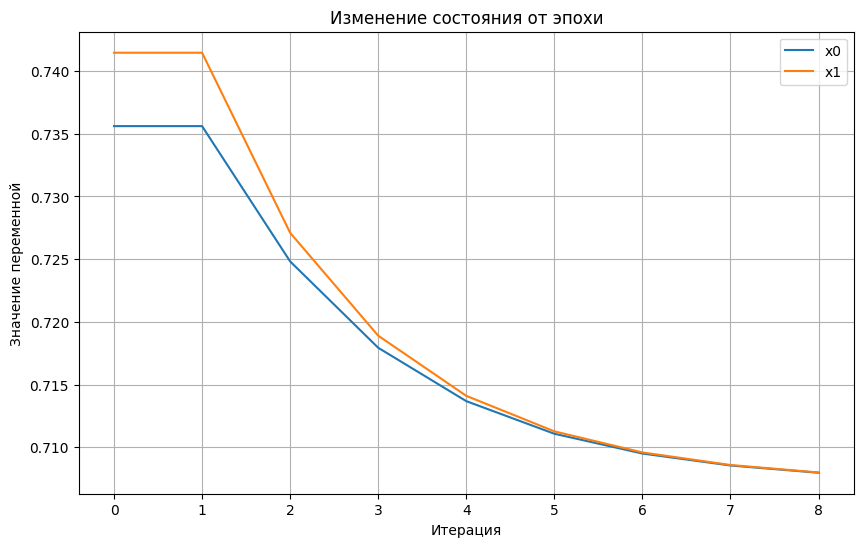

In [22]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  


plt.title('Изменение состояния от эпохи')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [23]:
verbose = verboses[2]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]

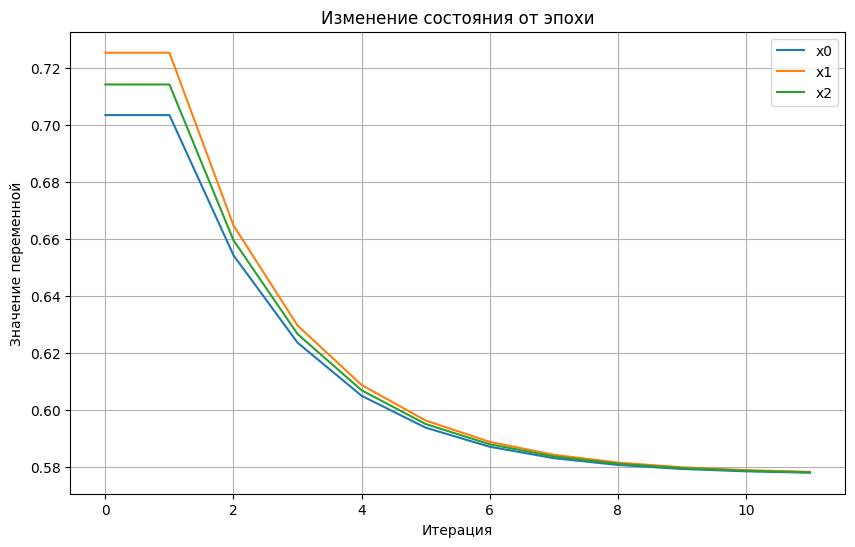

In [24]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  
plt.plot(u2_history.numpy(), label='x2')  


plt.title('Изменение состояния от эпохи')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [25]:
verbose = verboses[3]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]

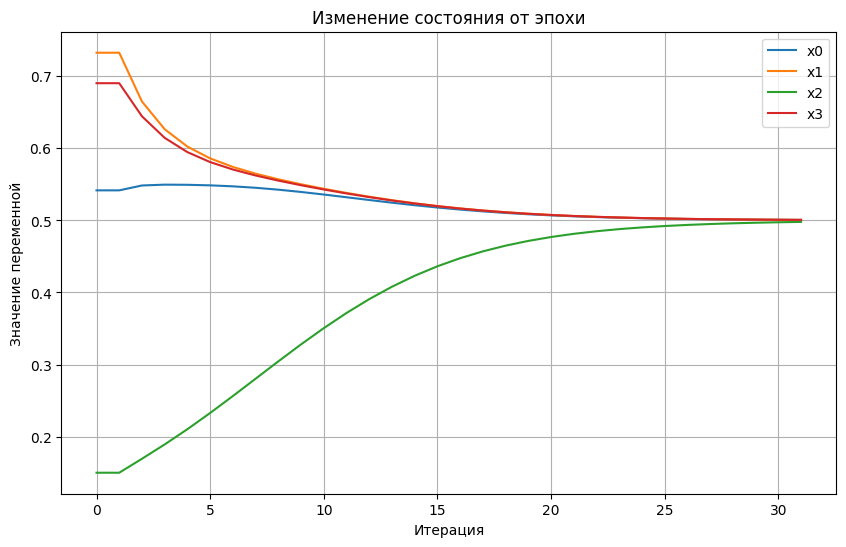

In [26]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  
plt.plot(u2_history.numpy(), label='x2')  
plt.plot(u3_history.numpy(), label='x3')  


plt.title('Изменение состояния от эпохи')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [27]:
verbose = verboses[9]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

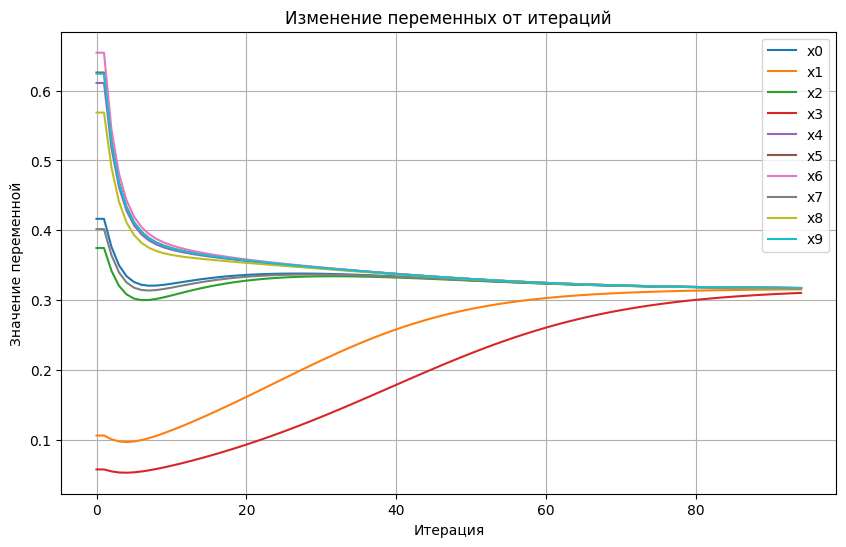

In [28]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  
plt.plot(u2_history.numpy(), label='x2') 
plt.plot(u3_history.numpy(), label='x3') 
plt.plot(u4_history.numpy(), label='x4') 
plt.plot(u5_history.numpy(), label='x5') 
plt.plot(u6_history.numpy(), label='x6') 
plt.plot(u7_history.numpy(), label='x7') 
plt.plot(u8_history.numpy(), label='x8') 
plt.plot(u9_history.numpy(), label='x9') 


plt.title('Изменение переменных от итераций')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [29]:
from IPython.display import display

In [30]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
grouped = results_df.groupby('Размерность')

# Пример: вывод сгруппированных данных
for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
0,Проекция,1,-1.000000,0.000000e+00,0.000000,2
1,Ньютон,1,-1.000000,0.000000e+00,0.001000,2
2,Экстраградиент,1,-1.000000,1.414337e-08,0.000946,45
3,Интервальный спуск,1,-1.000000,4.876703e-10,0.001397,26
4,Нейросетевой,1,-0.999996,4.272598e-06,0.001999,12


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
5,Проекция,2,-1.500000,0.001492,0.000,9
6,Ньютон,2,-1.000000,0.501492,0.000,8
7,Экстраградиент,2,-1.500000,0.001492,0.001,19
8,Интервальный спуск,2,-1.500000,0.001492,0.005,69
9,Нейросетевой,2,-1.501492,0.000000,0.002,9


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
10,Проекция,3,-1.666667,0.002294,0.000000,9
11,Ньютон,3,-1.000000,0.668960,0.000000,6
12,Экстраградиент,3,-1.666667,0.002294,0.000000,31
13,Интервальный спуск,3,-1.666667,0.002294,0.006166,87
14,Нейросетевой,3,-1.668960,0.000000,0.001003,12


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
15,Проекция,4,-1.750000,0.000000e+00,0.000000,19
16,Ньютон,4,-1.000000,7.500000e-01,0.000000,8
17,Экстраградиент,4,-1.750000,2.631311e-09,0.000000,60
18,Интервальный спуск,4,-1.750000,3.706760e-09,0.011323,158
19,Нейросетевой,4,-1.749991,8.768135e-06,0.005000,32


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
20,Проекция,5,-1.80000,0.000000e+00,0.000000,22
21,Ньютон,5,-1.00000,8.000000e-01,0.000000,5
22,Экстраградиент,5,-1.80000,3.286276e-09,0.001000,63
23,Интервальный спуск,5,-1.80000,5.050369e-09,0.007000,156
24,Нейросетевой,5,-1.79999,1.005371e-05,0.004334,31


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
25,Проекция,6,-1.833333,0.000000e+00,0.001000,26
26,Ньютон,6,-1.000000,8.333333e-01,0.000000,7
27,Экстраградиент,6,-1.833333,3.849726e-09,0.001002,74
28,Интервальный спуск,6,-1.833333,6.218329e-09,0.008997,185
29,Нейросетевой,6,-1.833324,9.282940e-06,0.004737,37


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
30,Проекция,7,-1.857143,0.000000e+00,0.001000,37
31,Ньютон,7,-1.000000,8.571429e-01,0.000000,5
32,Экстраградиент,7,-1.857143,5.157766e-09,0.001000,96
33,Интервальный спуск,7,-1.857143,6.889506e-09,0.012884,259
34,Нейросетевой,7,-1.857132,1.118140e-05,0.008003,55


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
35,Проекция,8,-1.875000,0.000000e+00,0.000000,53
36,Ньютон,8,-1.000000,8.750000e-01,0.000000,9
37,Экстраградиент,8,-1.875000,4.899686e-09,0.001997,128
38,Интервальный спуск,8,-1.875000,8.273776e-09,0.022076,396
39,Нейросетевой,8,-1.874982,1.811602e-05,0.012000,83


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
40,Проекция,9,-1.888889,0.000000e+00,0.000000,75
41,Ньютон,9,-1.000000,8.888889e-01,0.001004,7
42,Экстраградиент,9,-1.888889,6.282543e-09,0.001997,177
43,Интервальный спуск,9,-1.888889,8.989342e-09,0.034445,588
44,Нейросетевой,9,-1.888870,1.919361e-05,0.017998,130


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
45,Проекция,10,-1.900000,0.000000e+00,0.001000,62
46,Ньютон,10,-1.000000,9.000000e-01,0.000000,5
47,Экстраградиент,10,-1.900000,6.698832e-09,0.002530,148
48,Интервальный спуск,10,-1.900000,1.052234e-08,0.023573,444
49,Нейросетевой,10,-1.899983,1.703513e-05,0.009691,95


In [31]:
result = results_df.groupby('Имя метода').mean().reset_index()

display(result)

,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
0,Интервальный спуск,5.5,-1.707103,0.000379,0.013286,236.8
1,Нейросетевой,5.5,-1.707472,0.000010,0.006676,49.6
2,Ньютон,5.5,-1.000000,0.707482,0.000200,6.2
3,Проекция,5.5,-1.707103,0.000379,0.000300,31.4
4,Экстраградиент,5.5,-1.707103,0.000379,0.001147,84.1


Text(0, 0.5, 'Итерации')

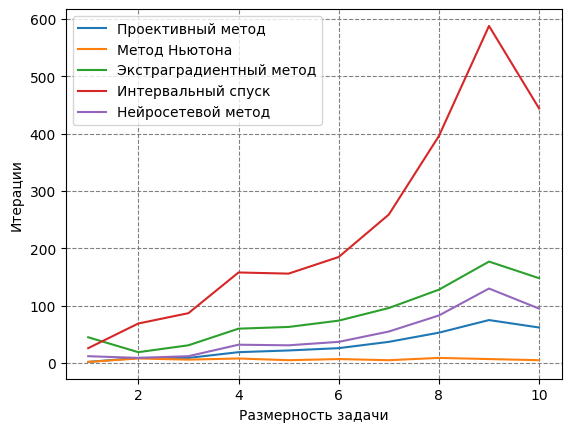

In [32]:
plt.grid(color='gray', linestyle='dashed')
plt.plot(range(1, 11), iters_proj, label='Проективный метод')
plt.plot(range(1, 11), iters_newton, label='Метод Ньютона')
plt.plot(range(1, 11), iters_extra, label='Экстраградиентный метод')
plt.plot(range(1, 11), iters_interval, label='Интервальный спуск')
plt.plot(range(1, 11), iters_neuro, label='Нейросетевой метод')
plt.legend()
plt.xlabel('Размерность задачи')
plt.ylabel('Итерации')

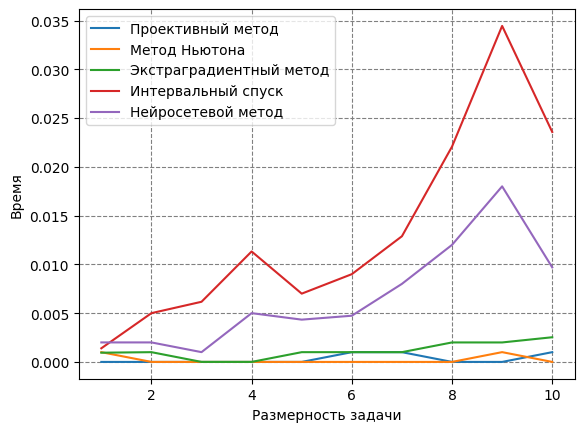

In [33]:
plt.grid(color='gray', linestyle='dashed')
plt.plot(range(1, 11), times_proj, label='Проективный метод')
plt.plot(range(1, 11), times_newton, label='Метод Ньютона')
plt.plot(range(1, 11), times_extra, label='Экстраградиентный метод')
plt.plot(range(1, 11), times_interval, label='Интервальный спуск')
plt.plot(range(1, 11), times_neuro, label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Время')
plt.legend(loc='upper left')

In [34]:
results_df['Невязка'] = results_df['Невязка'].astype(float)

# Группируем по методу и извлекаем значения невязки
residuals = results_df.groupby('Имя метода')['Невязка'].apply(list).reset_index()

# Преобразуем результат в список
residuals_list = residuals['Невязка'].tolist()

print(residuals_list[0])

[4.876703485479084e-10, 0.001492270632467818, 0.0022935439888891462, 3.7067602320917103e-09, 5.050369455972259e-09, 6.218328518770022e-09, 6.889505854701383e-09, 8.273775886635804e-09, 8.989341715448518e-09, 1.0522338333984749e-08]


In [35]:
residuals

,Имя метода,Невязка
0,Интервальный спуск,"[4.876703485479084e-10, 0.001492270632467818, ..."
1,Нейросетевой,"[4.2725984075175916e-06, 0.0, 0.0, 8.768135228..."
2,Ньютон,"[0.0, 0.5014922691330099, 0.6689602081160624, ..."
3,Проекция,"[0.0, 0.0014922691613616923, 0.002293541510912..."
4,Экстраградиент,"[1.4143374360564565e-08, 0.001492271463812589,..."


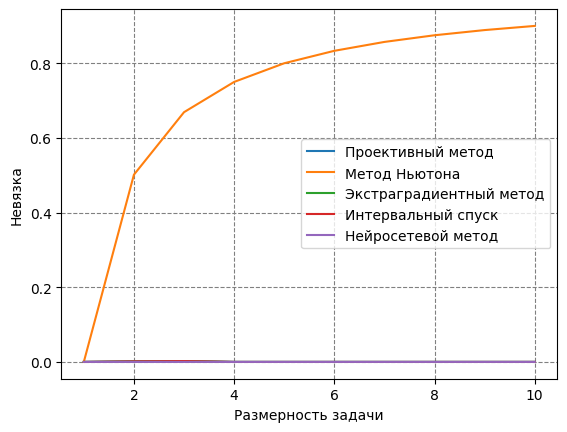

In [36]:
plt.rc('axes', axisbelow=True)
plt.plot(range(1, 11), residuals_list[3], label='Проективный метод')
plt.plot(range(1, 11), residuals_list[2], label='Метод Ньютона')
plt.plot(range(1, 11), residuals_list[4], label='Экстраградиентный метод')
plt.plot(range(1, 11), residuals_list[0], label='Интервальный спуск')
plt.plot(range(1, 11), residuals_list[1], label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

# Функция Растригина

In [37]:
def rastrigin(x):
    """
    Функция Растригина
    
    Параметры:
    x -- массив numpy или список координат (может быть многомерным)
    
    Возвращает:
    Значение функции Растригина в точке x
    """
    A = 10
    n = len(x)
    return A * n + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

In [38]:
def P_X(u, l, h):
    return torch.where(u < l, l, torch.where(u > h, h, u))

def P_ex1(u):
    return P_X(u, -5.12, 5.12)

In [39]:
def P_X_numpy(u, l, h):
    return np.where(u < l, l, np.where(u > h, h, u))

In [40]:
def P_numpy(u):
    return P_X_numpy(u, -5.12, 5.12)

In [41]:
def G(x):
    A = 10
    return 2 * np.array(x) + 2 * np.pi * A * np.sin(2 * np.pi * np.array(x))

In [42]:
def variational_inequality(G, x, proj_func, learning_rate=0.1, max_iter=1000, tol=1e-5):
    iter_count = 0
    verbose = []
    verbose.append(x)
    for _ in range(max_iter):
        iter_count += 1
        x_new = proj_func(x - learning_rate * G(x))
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
        verbose.append(x)
    return x, iter_count, verbose

In [43]:
def extragradient_method(G, x0, proj_func, learning_rate=0.1, max_iter=1000, tol=1e-5):
    x = x0
    iter_count = 0
    verbose = []
    verbose.append(x)
    for _ in range(max_iter):
        iter_count += 1
        y = proj_func(x - learning_rate * G(x))
        x_new = proj_func(x - learning_rate * G(y))
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
        verbose.append(x)
    return x, iter_count, verbose

In [44]:
def F_ex1(x):
    A = 10.0
    return 2 * x + 2 * torch.pi * A * torch.sin(2 * torch.pi * x)


In [45]:
P_numpy(np.array(0))

array(0.)

In [46]:
def test_f(n, results_dict, max_iter=1000, learning_rate=0.1):
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj, verbose_proj = variational_inequality(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    proj_time = time.time() - start_time
    value_proj = rastrigin(solution_proj)
    verboses_proj.append(verbose_proj)
    values.append(value_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(solution_proj)

    start_time = time.time()
    solution_extra, iter_count_extra, verbose_extra = extragradient_method(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    extra_time = time.time() - start_time
    value_extra = rastrigin(solution_extra)
    verboses_extra.append(verbose_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(solution_extra)

    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(solution_neuro.detach().numpy())
    value_neuro = rastrigin(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Точка'].append(solution)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [47]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

import numpy as np
import time
import matplotlib.pyplot as plt
import torch

iters_proj = []
iters_extra = []
iters_neuro = []
times_proj = []
times_extra = []
times_neuro = []
solutions_proj = []
solutions_extra = []
solutions_neuro = []
verboses_proj = []
verboses_extra = []
verboses = []
max_iter = 5000
learning_rate=0.01
integrator = EulerIntegrator(dt=learning_rate, max_iter=max_iter, max_dif=1e-5)
results_dict = {'Имя метода': [], 'Точка': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(50, 200, 10):
    test_f(n, results_dict, max_iter, learning_rate)

In [48]:

results_df = pd.DataFrame(results_dict)
results_df['Невязка'] = results_df['Невязка'].astype(float)

# Группируем по методу и извлекаем значения невязки
residuals = results_df.groupby('Имя метода')['Невязка'].apply(list).reset_index()

# Преобразуем результат в список
residuals_list = residuals['Невязка'].tolist()

In [49]:
residuals

,Имя метода,Невязка
0,Нейросетевой,"[164.64866138237403, 192.2251390143013, 179.22..."
1,Проекция,"[482.5343415376709, 540.2769556077269, 698.488..."
2,Экстраградиент,"[1379.2684970283904, 1618.29024234057, 1932.65..."


In [50]:
residuals_list[0]

[164.64866138237403,
 192.2251390143013,
 179.2214426925043,
 188.02273374215883,
 243.23380963726834,
 280.1323002565057,
 314.51656939440795,
 326.65272285073706,
 414.8499409245427,
 383.8242674349515,
 438.21012323425794,
 447.29717778821896,
 497.67125830016766,
 528.2752863523051,
 573.3537500872296]

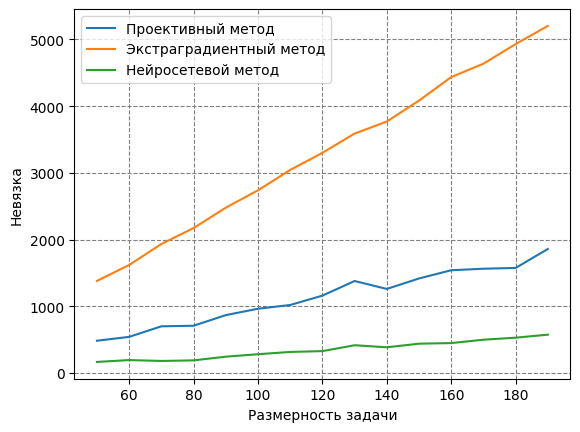

In [51]:
plt.rc('axes', axisbelow=True)
plt.plot(range(50, 200, 10), residuals_list[1], label='Проективный метод')
plt.plot(range(50, 200, 10), residuals_list[2], label='Экстраградиентный метод')
plt.plot(range(50, 200, 10), residuals_list[0], label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

In [52]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
grouped = results_df.groupby('Размерность')

# Пример: вывод сгруппированных данных
for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
0,Проекция,"[0.2948248935840054, -0.16798959863270693, 0.6...",50,482.534342,482.534342,0.071717,5000
1,Экстраградиент,"[-4.202772527426959, 5.12, -5.12, 5.12, -5.12,...",50,1379.268497,1379.268497,0.063580,2908
2,Нейросетевой,"[0.1044897959183673, -0.1044897959183673, 0.81...",50,164.648661,164.648661,0.872437,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
3,Проекция,"[0.299510814112684, 1.375034087747471, -0.0319...",60,540.276956,540.276956,0.084389,5000
4,Экстраградиент,"[4.2027725274269585, 4.2027725274269585, 5.12,...",60,1618.290242,1618.290242,0.052238,1838
5,Нейросетевой,"[0.1044897959183673, 0.9794312642100488, 0.104...",60,192.225139,192.225139,0.854243,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
6,Проекция,"[0.583726439025372, 0.03112789722806597, 0.292...",70,698.488078,698.488078,0.066648,5000
7,Экстраградиент,"[-5.12, -4.2027725274269585, 5.12, -5.12, -5.1...",70,1932.650684,1932.650684,0.044350,1498
8,Нейросетевой,"[0.8645192279301088, 0.1044897959183673, -0.10...",70,179.221443,179.221443,0.849376,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
9,Проекция,"[0.7352926362794718, 0.19692183312259615, 0.33...",80,707.039735,707.039735,0.066586,5000
10,Экстраградиент,"[5.12, 5.12, 4.202772527426959, -5.12, -4.2027...",80,2171.671821,2171.671821,0.040966,1533
11,Нейросетевой,"[0.9716904558628577, -0.10448979591836742, -0....",80,188.022734,188.022734,0.897183,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
12,Проекция,"[0.2549815716231299, 1.1879347979557162, -0.35...",90,866.307699,866.307699,0.075513,5000
13,Экстраградиент,"[-4.202772527426959, 4.2027725274269585, 4.202...",90,2477.660755,2477.660755,0.046442,1735
14,Нейросетевой,"[0.10448979591836743, 1.1488199599368794, -0.1...",90,243.233810,243.233810,0.880065,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
15,Проекция,"[1.1828821972260228, -0.1490989496248738, -0.1...",100,962.070419,962.070419,0.067887,5000
16,Экстраградиент,"[4.2027725274269585, -4.202772527426959, 5.12,...",100,2737.609747,2737.609747,0.059642,2905
17,Нейросетевой,"[0.8104622360177598, 0.1044897959183673, 0.104...",100,280.132300,280.132300,0.927995,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
18,Проекция,"[-0.35705674274206545, 1.3493756718947427, 1.3...",110,1018.453225,1018.453225,0.082239,5000
19,Экстраградиент,"[-5.12, 5.12, -5.12, 4.202772527426959, 4.2027...",110,3043.599534,3043.599534,0.078972,1997
20,Нейросетевой,"[-0.10448979591836743, 0.96901014569705, 0.945...",110,314.516569,314.516569,0.947026,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
21,Проекция,"[0.11831886019456778, 0.012782265354335267, 1....",120,1158.550118,1158.550118,0.099147,5000
22,Экстраградиент,"[-5.12, 5.12, 5.12, -4.2027725274269585, -4.20...",120,3299.363123,3299.363123,0.058484,1785
23,Нейросетевой,"[0.10448979591836743, 0.1044897959183673, 0.98...",120,326.652723,326.652723,0.958151,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
24,Проекция,"[-0.25115402588340396, 0.8739089760850451, 0.2...",130,1377.913698,1377.913698,0.068256,5000
25,Экстраградиент,"[5.12, -4.202772527426959, 5.12, 5.12, 5.12, -...",130,3588.609362,3588.609362,0.077967,2561
26,Нейросетевой,"[-0.1044897959183673, 1.0811485766566773, -0.1...",130,414.849941,414.849941,1.026520,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
27,Проекция,"[1.2888242387689413, -0.27171890087646533, 1.2...",140,1258.917771,1258.917771,0.098933,5000
28,Экстраградиент,"[4.2027725274269585, 4.2027725274269585, -5.12...",140,3769.034817,3769.034817,0.043521,1609
29,Нейросетевой,"[0.9792570028577554, 0.1044897959183673, 1.149...",140,383.824267,383.824267,1.006505,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
30,Проекция,"[0.142347294368332, 1.1709866767172228, 0.0343...",150,1416.194487,1416.194487,0.105107,5000
31,Экстраградиент,"[-5.12, -5.12, 4.202772527426959, 4.2027725274...",150,4083.394650,4083.394650,0.068364,2117
32,Нейросетевой,"[-0.1044897959183673, 1.0546499905312845, -0.1...",150,438.210123,438.210123,1.045965,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
33,Проекция,"[-0.07800544306711937, -0.22254336235564187, 0...",160,1539.184201,1539.184201,0.102460,5000
34,Экстраградиент,"[4.2027725274269585, 5.12, -5.12, -5.12, 5.12,...",160,4435.423985,4435.423985,0.063045,2059
35,Нейросетевой,"[-0.10448979591836743, 0.1044897959183673, 0.9...",160,447.297178,447.297178,1.022643,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
36,Проекция,"[-0.40039175358732304, -0.255090281861619, 0.8...",170,1562.184268,1562.184268,0.092209,5000
37,Экстраградиент,"[4.2027725274269585, 4.202772527426959, -4.202...",170,4636.776228,4636.776228,0.051273,1506
38,Нейросетевой,"[-0.1044897959183673, 0.10448979591836727, 0.7...",170,497.671258,497.671258,1.069152,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
39,Проекция,"[-0.35810203891760006, 1.2279653410931628, 0.9...",180,1573.952459,1573.952459,0.078000,5000
40,Экстраградиент,"[5.12, 5.12, -4.2027725274269585, -5.12, -4.20...",180,4930.209654,4930.209654,0.080000,2568
41,Нейросетевой,"[-0.10448979591836743, 0.8675051732458295, 1.0...",180,528.275286,528.275286,1.248433,5000


,Имя метода,Точка,Размерность,Значение,Невязка,Время,Количество_итераций
42,Проекция,"[0.7115945013678465, 0.6522466547378835, 0.579...",190,1858.418353,1858.418353,0.115001,5000
43,Экстраградиент,"[5.12, -4.2027725274269585, 5.12, 5.12, 4.2027...",190,5202.714155,5202.714155,0.105000,2654
44,Нейросетевой,"[1.0006911335436028, 0.9660547017168213, 0.975...",190,573.353750,573.353750,1.229000,5000


In [53]:
len(verboses_extra[0])

2908

In [54]:
verboses_proj[0]

[array([0.48476362, 0.33328528, 0.8092743 , 0.7924055 , 0.58668683,
        0.80390063, 0.64723128, 0.83372409, 0.15814147, 0.88325167,
        0.406153  , 0.50054637, 0.81642122, 0.21624018, 0.37392872,
        0.77587489, 0.89154469, 0.93265915, 0.23693193, 0.09191251,
        0.73485317, 0.63302861, 0.57447426, 0.29635011, 0.91839743,
        0.40128384, 0.21717781, 0.96474702, 0.99589471, 0.90375855,
        0.81460936, 0.31594931, 0.22540173, 0.10999767, 0.24015592,
        0.87968461, 0.33990521, 0.785107  , 0.16667935, 0.33313893,
        0.45677474, 0.97629332, 0.01499189, 0.7665574 , 0.3883048 ,
        0.37840702, 0.7069806 , 0.33563032, 0.45384027, 0.6918807 ]),
 array([ 0.41500939, -0.21761505,  1.37833319,  1.38270503,  0.90050715,
         1.38045149,  1.13610566,  1.36041646, -0.3715607 ,  1.28625332,
         0.04863655,  0.4926924 ,  1.37448378, -0.40232062, -0.08081858,
         1.38039059,  1.26950158,  1.17199531, -0.3940084 , -0.25294609,
         1.34563132,  1.08

In [55]:
residuals_proj = [rastrigin(verbose) for verbose in verboses_proj[0]]
residuals_extra = [rastrigin(verbose) for verbose in verboses_extra[0]]
residuals = [rastrigin(verbose) for verbose in verboses[0]]

C:\Users\znaev\AppData\Local\Temp\ipykernel_20940\2907644303.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return A * n + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])


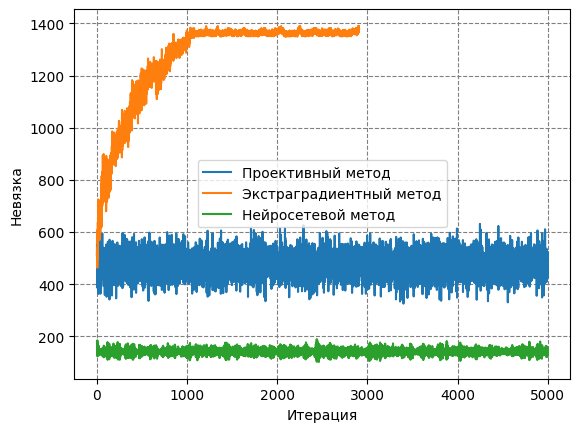

In [56]:
plt.rc('axes', axisbelow=True)
plt.plot(residuals_proj,  label='Проективный метод',)
plt.plot(residuals_extra,  label='Экстраградиентный метод')
plt.plot(residuals, label='Нейросетевой метод')
plt.xlabel('Итерация')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

# СЛАУ

In [57]:
def P_ex1(x):
    return x

def P_numpy(x):
    return x

In [58]:
import numpy as np
def G_t(x, n):

    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            A[i, j] = 1
            A[j, i] = -1
    
    b = np.zeros(n)
    
    H_x = A @ x - b
    
    return H_x


In [59]:
def check(x, n):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            A[i, j] = 1
            A[j, i] = -1
    
    b = np.zeros(n)
    
    H_x = A @ x - b

    return np.sum(np.abs(H_x))

In [60]:
G_t(np.array([0.1, 0.1]), 2)

array([ 0.1, -0.1])

In [61]:
def F(x, n):
    A = torch.zeros((n, n), dtype=torch.double)
    for i in range(n):
        for j in range(i + 1, n):
            A[i, j] = 1.0
            A[j, i] = -1.0

    b = torch.zeros(n, dtype=torch.double)
    
    H_x = A @ x - b
    
    return H_x

In [62]:
def test_f(n, results_dict, max_iter=1000, learning_rate=0.1):
    def F_ex1(x):
        return F(x, n)
    
    def G(x):
        return G_t(x, n)
    
    def check_func(x):
        return check(x, n)
   
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj, verbose_proj = variational_inequality(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    proj_time = time.time() - start_time
    value_proj = check_func(solution_proj)
    verboses_proj.append(verbose_proj)
    values.append(value_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(solution_proj)

    start_time = time.time()
    solution_extra, iter_count_extra, verbose_extra = extragradient_method(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    extra_time = time.time() - start_time
    verboses_extra.append(verbose_extra)
    value_extra = check_func(solution_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(solution_extra)

    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(solution_neuro.detach().numpy())
    value_neuro = check_func(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Точка'].append(solution)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [63]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

import numpy as np
import time
import matplotlib.pyplot as plt
import torch

iters_proj = []
iters_extra = []
iters_neuro = []
times_proj = []
times_extra = []
times_neuro = []
solutions_proj = []
solutions_extra = []
solutions_neuro = []
verboses = []
verboses_proj = []
verboses_extra = []
max_iter = 1000
learning_rate=0.001
integrator = EulerIntegrator(dt=learning_rate, max_iter=max_iter, max_dif=1e-5)
results_dict = {'Имя метода': [], 'Точка': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(1, 10, 1):
    test_f(n, results_dict, max_iter, learning_rate)

In [64]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
results_df = results_df.drop(columns='Невязка')
grouped = results_df.groupby('Размерность')

# Пример: вывод сгруппированных данных
for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
0,Проекция,[0.11499254425097771],1,0.0,0.0,1
1,Экстраградиент,[0.11499254425097771],1,0.0,0.0,1
2,Нейросетевой,[0.11499254425097771],1,0.0,0.0,1


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
3,Проекция,"[-0.10083840486827964, 0.7289665270584103]",2,0.829805,0.007,1000
4,Экстраградиент,"[-0.10073834515405447, 0.728237824519288]",2,0.828976,0.009,1000
5,Нейросетевой,"[-0.0030809724319180746, -0.7414416086558301]",2,0.744523,0.127,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
6,Проекция,"[-0.9875245609277937, -0.28101579262284154, 0....",3,2.948730,0.007001,1000
7,Экстраградиент,"[-0.9847863855652558, -0.2799590807961627, 0.4...",3,2.939891,0.015002,1000
8,Нейросетевой,"[-0.4004667148554658, 0.675485722209122, 0.856...",3,3.063540,0.158996,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
9,Проекция,"[-0.6713290769225573, -0.7698239446793134, -0....",4,5.567036,0.007000,1000
10,Экстраградиент,"[-0.6669541609140532, -0.7645288076927398, -0....",4,5.533909,0.012000,1000
11,Нейросетевой,"[-0.23672219169953299, -0.3817708534277301, -1...",4,5.808258,0.197002,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
12,Проекция,"[-0.2991878153378412, -0.1339990183534708, -1....",5,8.411974,0.008999,1000
13,Экстраградиент,"[-0.2950912087619001, -0.12690686961779826, -1...",5,8.332572,0.013002,1000
14,Нейросетевой,"[-0.13322649643184106, 0.9628117759424689, 1.4...",5,9.530640,0.236998,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
15,Проекция,"[0.11287877857019725, 0.7158067353849602, 0.00...",6,8.811863,0.012000,1000
16,Экстраградиент,"[0.10825041948445784, 0.714249281597165, 0.012...",6,8.701039,0.018002,1000
17,Нейросетевой,"[-0.2952086871848243, -1.3341294443670708, -0....",6,10.271134,0.309999,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
18,Проекция,"[0.2658108804738553, 0.5794853776828135, 0.122...",7,9.631949,0.010000,1000
19,Экстраградиент,"[0.2582519684612002, 0.5741072941283966, 0.121...",7,9.445817,0.017000,1000
20,Нейросетевой,"[0.6995967792596529, 0.9755141150344685, -0.10...",7,11.873579,0.345998,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
21,Проекция,"[0.8110050354181754, 0.597165062042182, 1.1578...",8,19.733268,0.012000,1000
22,Экстраградиент,"[0.7920211401626618, 0.578600145719667, 1.1428...",8,19.235583,0.019000,1000
23,Нейросетевой,"[-0.286682690679769, -0.6050566602878331, -0.0...",8,25.020376,0.436999,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
24,Проекция,"[0.9437073019705712, 0.7080122411064426, 1.098...",9,34.147799,0.01300,1000
25,Экстраградиент,"[0.923705209305491, 0.6801581071863007, 1.0659...",9,33.087028,0.02100,1000
26,Нейросетевой,"[0.7503278539245731, 0.6126874408706413, 0.045...",9,42.097445,0.48751,1000


In [65]:
residuals_proj = [check(verbose, 5) for verbose in verboses_proj[4]]
residuals_extra = [check(verbose, 5) for verbose in verboses_extra[4]]
residuals = [check(verbose.detach().numpy(), 5) for verbose in verboses[4]]

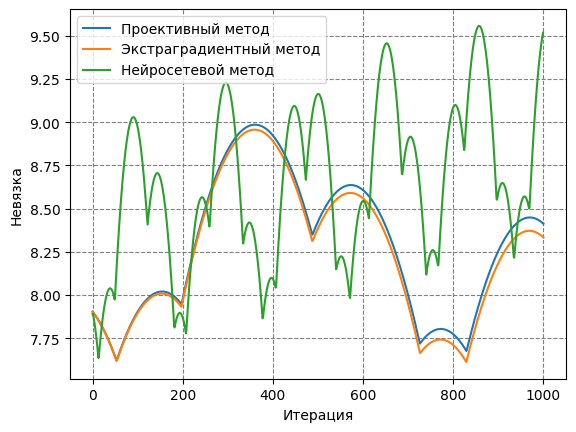

In [66]:
plt.rc('axes', axisbelow=True)
plt.plot(residuals_proj,  label='Проективный метод',)
plt.plot(residuals_extra,  label='Экстраградиентный метод')
plt.plot(residuals,  label='Нейросетевой метод')
plt.xlabel('Итерация')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

In [67]:

results_df = pd.DataFrame(results_dict)
results_df['Значение'] = results_df['Значение']

# Группируем по методу и извлекаем значения невязки
residuals = results_df.groupby('Имя метода')['Значение'].apply(list).reset_index()

# Преобразуем результат в список
residuals_list = residuals['Значение'].tolist()

In [68]:
residuals

,Имя метода,Значение
0,Нейросетевой,"[0.0, 0.7445225810877482, 3.0635395993524335, ..."
1,Проекция,"[0.0, 0.8298049319266899, 2.948729939270513, 5..."
2,Экстраградиент,"[0.0, 0.8289761696733424, 2.9398906614737137, ..."


In [69]:
residuals_list

[[0.0,
  0.7445225810877482,
  3.0635395993524335,
  5.808258187219704,
  9.530640044213861,
  10.271134301326832,
  11.873579080349238,
  25.02037633564546,
  42.09744486912656],
 [0.0,
  0.8298049319266899,
  2.948729939270513,
  5.567036018780307,
  8.411973590200757,
  8.8118629248733,
  9.631949342678983,
  19.733267742507437,
  34.14779862367321],
 [0.0,
  0.8289761696733424,
  2.9398906614737137,
  5.533909452464154,
  8.332572465641453,
  8.701039361947968,
  9.445817450509498,
  19.23558329216717,
  33.087028392600764]]

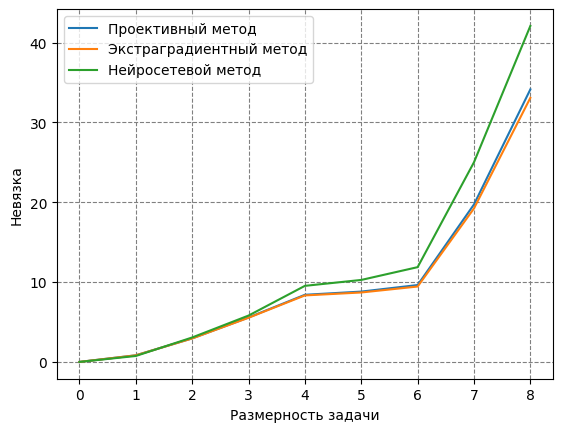

In [70]:
plt.rc('axes', axisbelow=True)
plt.plot(residuals_list[1], label='Проективный метод')
plt.plot(residuals_list[2], label='Экстраградиентный метод')
plt.plot(residuals_list[0], label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

# Функция сферы

In [71]:
def sphere(x):
    return np.sum(x ** 2)

def G(x):
    return 2*x

def F_ex1(x):
    return 2*x


In [72]:
def test_f(n, results_dict, max_iter=1000, learning_rate=0.1):
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj, verbose_proj = variational_inequality(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    proj_time = time.time() - start_time
    value_proj = sphere(solution_proj)
    values.append(value_proj)
    verboses_proj.append(verbose_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(solution_proj)

    start_time = time.time()
    solution_extra, iter_count_extra, verbose_extra = extragradient_method(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    extra_time = time.time() - start_time
    verboses_extra.append(verbose_extra)
    value_extra = sphere(solution_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(solution_extra)

    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(solution_neuro.detach().numpy())
    value_neuro = sphere(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Точка'].append(solution)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [73]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

import numpy as np
import time
import matplotlib.pyplot as plt
import torch

iters_proj = []
iters_extra = []
iters_neuro = []
times_proj = []
times_extra = []
times_neuro = []
solutions_proj = []
solutions_extra = []
solutions_neuro = []
verboses = []
verboses_proj = []
verboses_extra = []
max_iter = 1000
learning_rate=0.01
integrator = EulerIntegrator(dt=learning_rate, max_iter=max_iter, max_dif=1e-5)
results_dict = {'Имя метода': [], 'Точка': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(100, 1000, 100):
    test_f(n, results_dict, max_iter, learning_rate)

In [74]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
results_df = results_df.drop(columns='Невязка')
grouped = results_df.groupby('Размерность')

for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
0,Проекция,"[2.8888744267995628e-05, 8.313153252393408e-05...",100,2.481756e-07,0.002997,461
1,Экстраградиент,"[2.916639518477814e-05, 8.39305131235987e-05, ...",100,2.529690e-07,0.004999,470
2,Нейросетевой,"[7.653270869192039e-07, 2.202339188836114e-06,...",100,1.741791e-10,0.016000,155


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
3,Проекция,"[7.720554331259474e-06, 1.8787221923021254e-06...",200,2.484967e-07,0.003001,481
4,Экстраградиент,"[7.858634903480786e-06, 1.912322763482308e-06,...",200,2.574648e-07,0.002998,490
5,Нейросетевой,"[1.4465579479378215e-07, 3.520058797123267e-08...",200,8.723593e-11,0.021000,164


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
6,Проекция,"[4.062372415614967e-06, 6.2874491017180055e-06...",300,2.488961e-07,0.003000,492
7,Экстраградиент,"[4.153630497921258e-06, 6.428691826145649e-06,...",300,2.602042e-07,0.003999,501
8,Нейросетевой,"[5.7637776458257124e-08, 8.920762272422822e-08...",300,5.010407e-11,0.023001,170


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
9,Проекция,"[3.388358098729922e-05, 1.3797461610457097e-05...",400,2.477732e-07,0.004999,500
10,Экстраградиент,"[3.407677958662521e-05, 1.387613246459125e-05,...",400,2.506068e-07,0.006003,510
11,Нейросетевой,"[4.400192361010617e-07, 1.7917670863191052e-07...",400,4.178487e-11,0.026999,173


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
12,Проекция,"[1.607386566317946e-05, 3.0505587847758525e-05...",500,2.414199e-07,0.002998,505
13,Экстраградиент,"[1.6522372490882504e-05, 3.135678100312728e-05...",500,2.550804e-07,0.006001,514
14,Нейросетевой,"[1.7981909110923034e-07, 3.4126744589525594e-0...",500,3.021370e-11,0.032999,176


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
15,Проекция,"[4.444880001124137e-06, 8.455863911635167e-09,...",600,2.461300e-07,0.003000,509
16,Экстраградиент,"[4.486672041621814e-06, 8.535368376761001e-09,...",600,2.507802e-07,0.005000,519
17,Нейросетевой,"[4.562962047042832e-08, 8.680501182032418e-11,...",600,2.593811e-11,0.034001,178


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
18,Проекция,"[8.391579616709771e-06, 1.651391135852926e-05,...",700,2.486916e-07,0.005000,511
19,Экстраградиент,"[8.477395750835094e-06, 1.6682790174772125e-05...",700,2.538040e-07,0.008000,521
20,Нейросетевой,"[8.252132851052331e-08, 1.6239492043873095e-07...",700,2.404950e-11,0.037002,179


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
21,Проекция,"[1.737508026994376e-05, 2.1815887886602403e-05...",800,2.418567e-07,0.005998,516
22,Экстраградиент,"[1.7940245837430512e-05, 2.2525501221683602e-0...",800,2.578465e-07,0.008002,525
23,Нейросетевой,"[1.5999064436883846e-07, 2.008818322694953e-07...",800,2.050660e-11,0.043000,181


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
24,Проекция,"[1.7624685460165028e-05, 2.8034988486274814e-0...",900,2.433281e-07,0.006000,519
25,Экстраградиент,"[1.822026235166804e-05, 2.89823524170364e-05, ...",900,2.600511e-07,0.007998,528
26,Нейросетевой,"[1.4594410937518324e-07, 2.3214833735447482e-0...",900,1.668486e-11,0.051001,183


In [75]:
residuals_proj = [sphere(verbose) for verbose in verboses_proj[4]]
residuals_extra = [sphere(verbose) for verbose in verboses_extra[4]]
residuals = [sphere(verbose.detach().numpy()) for verbose in verboses[4]]

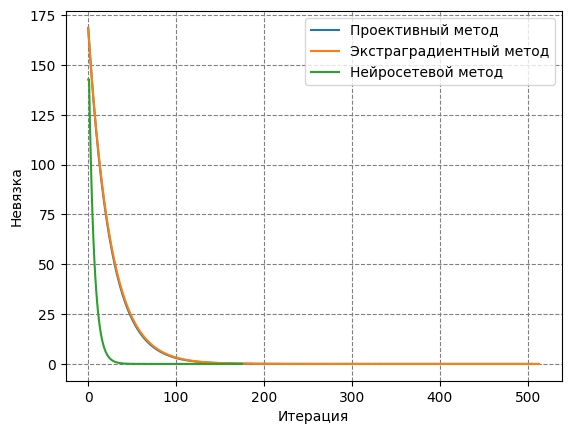

In [76]:
plt.rc('axes', axisbelow=True)
plt.plot(residuals_proj, label='Проективный метод',)
plt.plot(residuals_extra,  label='Экстраградиентный метод')
plt.plot(residuals, label='Нейросетевой метод')
plt.xlabel('Итерация')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

In [77]:

results_df = pd.DataFrame(results_dict)
results_df['Значение'] = results_df['Значение']

# Группируем по методу и извлекаем значения невязки
residuals = results_df.groupby('Имя метода')['Значение'].apply(list).reset_index()

# Преобразуем результат в список
residuals_list = residuals['Значение'].tolist()

In [78]:
residuals

,Имя метода,Значение
0,Нейросетевой,"[1.7417905255569842e-10, 8.723592777257573e-11..."
1,Проекция,"[2.4817560190567316e-07, 2.484967308726862e-07..."
2,Экстраградиент,"[2.5296897837368824e-07, 2.5746484534903526e-0..."


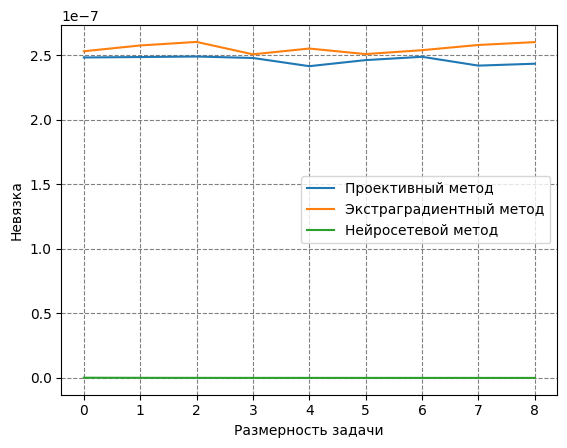

In [79]:
plt.rc('axes', axisbelow=True)
plt.plot(residuals_list[1], label='Проективный метод')
plt.plot(residuals_list[2], label='Экстраградиентный метод')
plt.plot(residuals_list[0], label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

# Функция Розенброка

In [80]:
def rosenbroke(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

In [81]:
def G(x):
    grad = np.zeros_like(x)
    grad[0] = -2 * (1 - x[0]) - 4 * 100 * x[0] * (x[1] - x[0]**2)
    grad[-1] = 2 * 100 * (x[-1] - x[-2]**2)
    
    for i in range(1, len(x) - 1):
        grad[i] = 2 * 100 * (x[i] - x[i-1]**2) - 2 * (1 - x[i]) - 4 * 100 * x[i] * (x[i+1] - x[i]**2)
    
    return grad

def F_ex1(x):
    grad = torch.zeros_like(x)
    grad[0] = -2 * (1 - x[0]) - 4 * 100 * x[0] * (x[1] - x[0]**2)
    grad[-1] = 2 * 100 * (x[-1] - x[-2]**2)
    
    for i in range(1, len(x) - 1):
        grad[i] = 2 * 100 * (x[i] - x[i-1]**2) - 2 * (1 - x[i]) - 4 * 100 * x[i] * (x[i+1] - x[i]**2)
    
    return grad

In [82]:
def test_f(n, results_dict, max_iter=1000, learning_rate=0.1):
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj, verbose_proj = variational_inequality(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    proj_time = time.time() - start_time
    value_proj = rosenbroke(solution_proj)
    values.append(value_proj)
    verboses_proj.append(verbose_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(solution_proj)

    start_time = time.time()
    solution_extra, iter_count_extra, verbose_extra = extragradient_method(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    extra_time = time.time() - start_time
    value_extra = rosenbroke(solution_extra)
    values.append(value_extra)
    verboses_extra.append(verbose_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(solution_extra)

    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(solution_neuro.detach().numpy())
    value_neuro = rosenbroke(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Точка'].append(solution)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [83]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

import numpy as np
import time
import matplotlib.pyplot as plt
import torch

iters_proj = []
iters_extra = []
iters_neuro = []
times_proj = []
times_extra = []
times_neuro = []
solutions_proj = []
solutions_extra = []
solutions_neuro = []
verboses = []
verboses_proj = []
verboses_extra = []
max_iter = 10000
learning_rate=1e-4
integrator = EulerIntegrator(dt=learning_rate, max_iter=max_iter, max_dif=1e-5)
results_dict = {'Имя метода': [], 'Точка': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(3, 10, 1):
    test_f(n, results_dict, max_iter, learning_rate)

In [84]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
results_df = results_df.drop(columns='Невязка')
grouped = results_df.groupby('Размерность')

for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
0,Проекция,"[0.8842062024567483, 0.7814062745311456, 0.609...",3,0.061348,0.079000,10000
1,Экстраградиент,"[0.8844690848702101, 0.7818720615881286, 0.610...",3,0.061083,0.112998,10000
2,Нейросетевой,"[0.9796971232068973, 0.9597294056008877, 0.920...",3,0.002038,2.498968,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
3,Проекция,"[0.917917330768805, 0.8423329799523134, 0.7088...",4,0.116691,0.092998,10000
4,Экстраградиент,"[0.9179475778328653, 0.8423885689202767, 0.708...",4,0.116613,0.198998,10000
5,Нейросетевой,"[0.9882722333647409, 0.9766387423812876, 0.953...",4,0.002833,3.285170,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
6,Проекция,"[0.9484868138463087, 0.8995049223253799, 0.808...",5,0.169988,0.140001,10000
7,Экстраградиент,"[0.9485110924980815, 0.8995509997824012, 0.808...",5,0.169851,0.194508,10000
8,Нейросетевой,"[0.9935352982879524, 0.9870888605411683, 0.974...",5,0.003469,3.893382,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
9,Проекция,"[0.9696165952705854, 0.9400978430757009, 0.883...",6,0.220354,0.138998,10000
10,Экстраградиент,"[0.9696293478760707, 0.9401225751420939, 0.883...",6,0.220202,0.183000,10000
11,Нейросетевой,"[0.9965406247017541, 0.993080720171163, 0.9861...",6,0.003980,4.888753,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
12,Проекция,"[0.9827920549056673, 0.9658536370051793, 0.932...",7,0.266598,0.152003,10000
13,Экстраградиент,"[0.9831504563901825, 0.9665577719397546, 0.934...",7,0.257852,0.203004,10000
14,Нейросетевой,"[0.9981618267713632, 0.99632042636604, 0.99263...",7,0.004499,5.424626,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
15,Проекция,"[0.9963620557680319, 0.9927264420706317, 0.985...",8,0.061173,0.163075,10000
16,Экстраградиент,"[0.9963856054922008, 0.9927734204702481, 0.985...",8,0.060458,0.213521,10000
17,Нейросетевой,"[0.9994283895354937, 0.9988550175809262, 0.997...",8,0.001780,6.357360,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
18,Проекция,"[0.9949427343097755, 0.9899061119519862, 0.979...",9,0.339409,0.188019,10000
19,Экстраградиент,"[0.995012194936946, 0.990044160992802, 0.98017...",9,0.332423,0.238019,10000
20,Нейросетевой,"[0.9995176301118366, 0.999033767045308, 0.9980...",9,0.004985,6.992431,10000


In [85]:
residuals_proj = [rosenbroke(verbose) for verbose in verboses_proj[2]]
residuals_extra = [rosenbroke(verbose) for verbose in verboses_extra[2]]
residuals = [rosenbroke(verbose.detach().numpy()) for verbose in verboses[2]]

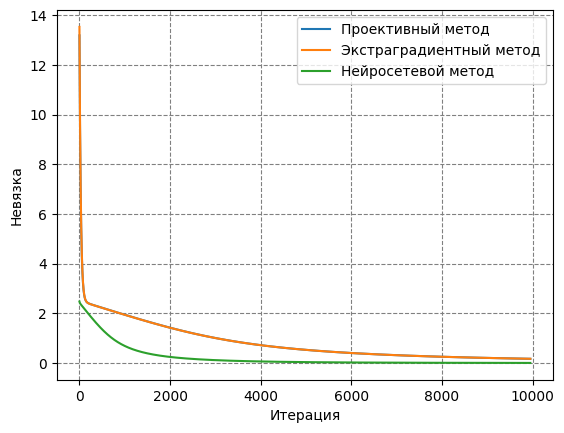

In [86]:
plt.rc('axes', axisbelow=True)
plt.plot(residuals_proj[50:],  label='Проективный метод',)
plt.plot(residuals_extra[50:],  label='Экстраградиентный метод')
plt.plot(residuals[50:], label='Нейросетевой метод')
plt.xlabel('Итерация')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

In [87]:

results_df = pd.DataFrame(results_dict)
results_df['Значение'] = results_df['Значение']

# Группируем по методу и извлекаем значения невязки
residuals = results_df.groupby('Имя метода')['Значение'].apply(list).reset_index()

# Преобразуем результат в список
residuals_list = residuals['Значение'].tolist()

In [88]:
residuals

,Имя метода,Значение
0,Нейросетевой,"[0.002038390079405812, 0.002832647089381502, 0..."
1,Проекция,"[0.0613482563863123, 0.11669069393644627, 0.16..."
2,Экстраградиент,"[0.061083295940223006, 0.11661332856646202, 0...."


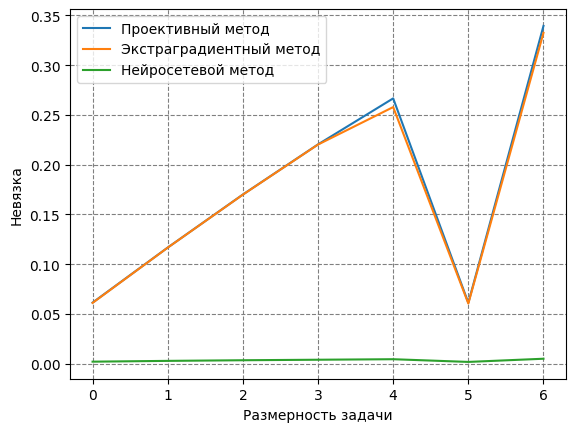

In [89]:
plt.rc('axes', axisbelow=True)
plt.plot(residuals_list[1], label='Проективный метод')
plt.plot(residuals_list[2], label='Экстраградиентный метод')
plt.plot(residuals_list[0], label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

# Модель пространства состояний

In [90]:
def G_ex1(x):
    return x

def G_numpy(x):
    return x


def project(x):
    norm = np.linalg.norm(x)
    # return x / norm
    if norm > 2:
        return x / norm
    return x


def P_ex1(u):
    return project(u)


In [91]:
class SSM(torch.nn.Module):
    
    def __init__(self, A, B, C):
        super().__init__()

        wA = A
        wB = B
        wC = C
        self.ni = wB.shape[1]
        self.no = wC.shape[0]
        self.nsv = wA.shape[0]
        self.A = torch.nn.Parameter(A)
        self.B = torch.nn.Parameter(B)
        self.C = torch.nn.Parameter(C)
    

    @staticmethod
    def auto_init(ni, no, nsv):
        A = torch.rand([nsv, nsv], requires_grad=True) * 2 - 1
        B = torch.rand([nsv, ni], requires_grad=True) * 2 - 1
        C = torch.rand([no, nsv], requires_grad=True) * 2 - 1
        return SSM(A, B, C)
        

    def forward(self, u, x0 = None):
        """
            - u: LEN_OF_TS x NUM_OF_INPUTS
            - x: NUM_OF_STATE_VARS
        """
        if type(x0) is None:
            x = torch.zeros((self.nsv))
        else:
            x = x0
        y = torch.zeros([u.shape[0], self.no])
        x_hist = torch.zeros([u.shape[0], self.nsv])
        for (i, u_i) in enumerate(u):
            y[i] += self.C @ x
            x = self.A @ x +self.B @ u_i
            x_hist[i] += x
        return y, x_hist

In [92]:
NSV = 20
NI = 10
NO = 5
TS_LENGTH = 20
GS = max([NSV, NI, NO])
U = torch.tensor([[
    i > 5, 
    (i > 2) and (i < 8), 
    (i > 6) and (i < 10) or (i > 15), 
    np.sin(i * torch.pi / TS_LENGTH), 
    (np.sin(i * torch.pi / TS_LENGTH * 2) + 1) / 2, 
    (np.sin(i * torch.pi / TS_LENGTH * 3) + 1) / 2, 
    (np.sin(i * torch.pi / TS_LENGTH * 4) + 1) / 2, 
    (np.sin(i * torch.pi / TS_LENGTH * 5) + 1) / 2, 
    (np.cos(i * torch.pi / TS_LENGTH * 2) + 1) / 2, 
    (np.cos(i * torch.pi / TS_LENGTH * 3) + 1) / 2
] for i in range(TS_LENGTH)], dtype=torch.float32)
X0 = torch.zeros([NSV])
M_start = SSM.auto_init(nsv=NSV, ni=NI, no=NO)
with torch.no_grad():
    Y, _ = M_start(U, X0)
    Y = (Y - Y.min()) / (Y.max() - Y.min())
    Y = Y - Y[0]
LOSS = torch.nn.MSELoss(reduction='mean')

In [93]:
def get_ssm_from_v(u):
    slice1 = NSV * NSV
    slice2 = slice1 + NSV * NI
    slice3 = slice2 + NSV * NO
    A = u[:slice1].reshape(NSV, NSV)
    B = u[slice1:slice2].reshape(NSV, NI)
    C = u[slice2:slice3].reshape(NO, NSV)
    m = SSM(A, B, C)
    return m

In [94]:
sp = torch.ones([NSV * NSV + NSV * NI + NSV * NO]) * 1

In [95]:
def variational_inequality(G, x, proj_func, learning_rate=0.1, max_iter=1000, tol=1e-5):
    iter_count = 0
    verbose = []
    verbose.append(x)
    for _ in range(max_iter):
        iter_count += 1
        x_new = proj_func(x - learning_rate * G(x))
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
        verbose.append(x)
        
    return x, iter_count, verbose


def extragradient_method(G, x0, proj_func, learning_rate=0.1, max_iter=1000, tol=1e-5):
    x = x0
    iter_count = 0
    verbose = []
    verbose.append(x)
    for _ in range(max_iter):
        iter_count += 1
        y = proj_func(x - learning_rate * G(x))
        x_new = proj_func(x - learning_rate * G(y))
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
        verbose.append(x)
    return x, iter_count, verbose

In [96]:
def F_ex_grad(u):
    m = get_ssm_from_v(u)
    p, _ = m(U, X0)
    l = LOSS(p, Y)
    l.backward()
    gAp = m.A.grad
    gBp = m.B.grad
    gCp = m.C.grad
    d =  np.concat([gAp.reshape(-1), gBp.reshape(-1), gCp.reshape(-1)])
    return d

In [97]:
def F_ex_grad_numpy(u):
    u = torch.from_numpy(u)
    m = get_ssm_from_v(u)
    p, _ = m(U, X0)
    l = LOSS(p, Y)
    l.backward()
    gAp = m.A.grad
    gBp = m.B.grad
    gCp = m.C.grad
    d =  np.concat([gAp.reshape(-1), gBp.reshape(-1), gCp.reshape(-1)])
    return d

In [98]:
from copy import deepcopy
import time

from SVI_solver_library.solver.ProjSolver import ProjSolver
from SVI_solver_library.transform.AdapterTransform import AdapterTransform
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

def test_f(results_dict, max_iter=1000, learning_rate=0.0001):
    # M = deepcopy(M_start)
    u_ex = torch.rand([NSV * NSV + NSV * NI + NSV * NO]) * 2 - 1
    Mt = get_ssm_from_v(u_ex)
    x0 = u_ex.numpy()

    values = []

    # M = deepcopy(Mt)

    start_time = time.time()
    solution_proj, iter_count_proj, verbose_proj = variational_inequality(F_ex_grad, u_ex, P_ex1, max_iter=max_iter, learning_rate=learning_rate)
    proj_time = time.time() - start_time
    m = get_ssm_from_v(solution_proj)
    p, _ = m(U, X0)
    value_proj = LOSS(p, Y).item()
    values.append(value_proj)
    verboses_proj.append(verbose_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(solution_proj)

    M = deepcopy(Mt)

    start_time = time.time()
    solution_extra, iter_count_extra, verbose_extra = extragradient_method(F_ex_grad, u_ex, P_ex1, max_iter=max_iter, learning_rate=learning_rate)
    extra_time = time.time() - start_time
    m = get_ssm_from_v(solution_extra)
    p, _ = m(U, X0)
    value_extra = LOSS(p, Y).item()
    verboses_extra.append(verbose_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(solution_extra)

    # M = deepcopy(Mt)

    Ex_solver = ProjSolver(AdapterTransform(F_ex_grad), sp, P=AdapterTransform(P_ex1), G=AdapterTransform(G_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(solution_neuro.detach().numpy())
    m = get_ssm_from_v(solution_neuro)
    p, _ = m(U, X0)
    value_neuro = LOSS(p, Y).item()
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append((NSV, NI, NO))
        results_dict['Точка'].append(solution)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [105]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

import numpy as np
import time
# import matplotlib.pyplot as plt
import torch

iters_proj = []
iters_extra = []
iters_neuro = []
times_proj = []
times_extra = []
times_neuro = []
solutions_proj = []
solutions_extra = []
solutions_neuro = []
verboses = []
verboses_proj = []
verboses_extra = []
max_iter = 10000
learning_rate=1e-4
# integrator = EulerIntegrator(dt=learning_rate, max_iter=max_iter, max_dif=1e-5)
integrator = EulerIntegrator()
results_dict = {'Имя метода': [], 'Точка': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


test_f(results_dict, max_iter=max_iter)

C:\Users\znaev\AppData\Local\Temp\ipykernel_20940\27495670.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_new = proj_func(x - learning_rate * G(x))
C:\Users\znaev\AppData\Local\Temp\ipykernel_20940\27495670.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = proj_func(x - learning_rate * G(x))
C:\Users\znaev\AppData\Local\Temp\ipykernel_20940\27495670.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_new = proj_func(x - learning_rate * G(y))


In [106]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
results_df = results_df.drop(columns='Невязка')
grouped = results_df.groupby('Размерность')

for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
0,Проекция,"[tensor(0.0112), tensor(-0.0653), tensor(-0.11...","(20, 10, 5)",0.008168,0.008671,2
1,Экстраградиент,"[tensor(0.0134), tensor(0.0408), tensor(-0.013...","(20, 10, 5)",0.008410,0.011751,2
2,Нейросетевой,"[0.021911405, 0.06320386, -0.037844963, 0.0692...","(20, 10, 5)",0.008051,3.273023,1000
